In [0]:
# ==============================
# 0) Environment & Installs
# ==============================

%pip install -U cfgrib eccodes xarray herbie-data zarr numcodecs pandas pyarrow fsspec s3fs gcsfs adlfs
%pip install -U "boto3==1.40.18"

%pip uninstall -y eccodes eccodeslib eckitlib fckitlib cfgrib
%pip install --force-reinstall \
  "xarray==2024.3.0" \
  "cfgrib==0.9.14.1" \
  "eccodes==2.39.2" "eccodeslib==2.39.2"

# Regridding deps (no xesmf wheels here)
%pip install pyresample==1.27.1 pyproj shapely

# Cartopy (conda forge wheels)
%pip install --upgrade pip
%pip install --extra-index-url=https://conda.anaconda.org/conda-forge cartopy

# CPU torch
%pip install --index-url https://download.pytorch.org/whl/cpu "torch==2.4.1"

dbutils.library.restartPython()

DEPRECATION: Using the pkg_resources metadata backend is deprecated. pip 26.3 will enforce this behaviour change. A possible replacement is to use the default importlib.metadata backend, by unsetting the _PIP_USE_IMPORTLIB_METADATA environment variable. Discussion can be found at https://github.com/pypa/pip/issues/13317
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.8 MB/s  0:00:00
  Attempting uninstall: eccodes
    Found existing installation: eccodes 2.39.2
    Uninstalling eccodes-2.39.2:
      Successfully uninstalled eccodes-2.39.2
  Attempting uninstall: xarray
    Found existing installation: xarray 2024.3.0
    Uninstalling xarray-2024.3.0:
      Successfully uninstalled xarray-2024.3.0
  Attempting uninstall: cfgrib
    Found existing installation: cfgrib 0.9.14.1
    Uninstalling cfgrib-0.9.14.1:
      Successfully uninstalled cfgrib-0.9.14.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [cfgrib]
Note: you may need to restart the kernel using %restart_python or 

In [0]:
# # ==============================
# # Reset utilities (Bronze/Silver/Gold)
# # ==============================
# from pyspark.sql import functions as F

# # Choose: "window" or "all"
# CLEAR_MODE = "all"

# # Also clear model/scaler + caches?
# CLEAR_ARTIFACTS = True
# CLEAR_CACHES    = True

# def _ts(s):  # ensure ISO strings (naive UTC)
#     return pd.to_datetime(s, utc=True).tz_localize(None).strftime("%Y-%m-%d %H:%M:%S")

# start_iso = _ts(ONLINE_START)
# end_iso   = _ts(ONLINE_END)

# print(f"Reset mode = {CLEAR_MODE} | window = [{start_iso} .. {end_iso}]")

# # --- Tables we manage ---
# tbl_bronze_gfs   = f"{BRONZE}.bronze_gfs_grid"
# tbl_bronze_urma  = f"{BRONZE}.bronze_urma_grid"
# tbl_ingest_log   = f"{BRONZE}.bronze_ingest_log"

# tbl_silver_urma_on_gfs = f"{SILVER}.silver_urma_on_gfs"
# tbl_silver_gfs_feat    = f"{SILVER}.silver_gfs_features"

# tbl_gold_preds   = f"{GOLD}.predictions_grid_online"
# tbl_gold_log     = f"{GOLD}.online_training_log"
# tbl_gold_metrics = f"{GOLD}.daily_metrics"

# def _sql(q): 
#     print(q.strip().splitlines()[0] + " ...")
#     spark.sql(q)

# if CLEAR_MODE == "window":
#     # Bronze
#     _sql(f"DELETE FROM {tbl_bronze_gfs}  WHERE run_time BETWEEN TIMESTAMP '{start_iso}' AND TIMESTAMP '{end_iso}'")
#     _sql(f"DELETE FROM {tbl_bronze_gfs}  WHERE valid_time BETWEEN TIMESTAMP '{start_iso}' AND TIMESTAMP '{end_iso}'")
#     _sql(f"DELETE FROM {tbl_bronze_urma} WHERE valid_time BETWEEN TIMESTAMP '{start_iso}' AND TIMESTAMP '{end_iso}'")
#     _sql(f"DELETE FROM {tbl_ingest_log}  WHERE ts BETWEEN TIMESTAMP '{start_iso}' AND TIMESTAMP '{end_iso}' OR run_time BETWEEN TIMESTAMP '{start_iso}' AND TIMESTAMP '{end_iso}' OR valid_time BETWEEN TIMESTAMP '{start_iso}' AND TIMESTAMP '{end_iso}'")

#     # Silver
#     _sql(f"DELETE FROM {tbl_silver_urma_on_gfs} WHERE valid_time BETWEEN TIMESTAMP '{start_iso}' AND TIMESTAMP '{end_iso}'")
#     _sql(f"DELETE FROM {tbl_silver_gfs_feat}    WHERE run_time   BETWEEN TIMESTAMP '{start_iso}' AND TIMESTAMP '{end_iso}' OR valid_time BETWEEN TIMESTAMP '{start_iso}' AND TIMESTAMP '{end_iso}'")

#     # Gold
#     _sql(f"DELETE FROM {tbl_gold_preds}   WHERE issue_time BETWEEN TIMESTAMP '{start_iso}' AND TIMESTAMP '{end_iso}' OR valid_time BETWEEN TIMESTAMP '{start_iso}' AND TIMESTAMP '{end_iso}'")
#     _sql(f"DELETE FROM {tbl_gold_log}     WHERE issue_time BETWEEN TIMESTAMP '{start_iso}' AND TIMESTAMP '{end_iso}' OR valid_time BETWEEN TIMESTAMP '{start_iso}' AND TIMESTAMP '{end_iso}'")
#     _sql(f"DELETE FROM {tbl_gold_metrics} WHERE day BETWEEN DATE '{start_iso[:10]}' AND DATE '{end_iso[:10]}'")

# elif CLEAR_MODE == "all":
#     # Truncate (keeps schemas)
#     for t in [tbl_bronze_gfs, tbl_bronze_urma, tbl_ingest_log,
#               tbl_silver_urma_on_gfs, tbl_silver_gfs_feat,
#               tbl_gold_preds, tbl_gold_log, tbl_gold_metrics]:
#         _sql(f"TRUNCATE TABLE {t}")
# else:
#     raise ValueError("CLEAR_MODE must be 'window' or 'all'")

# # --- Optional: clear Volumes content (keeps the volumes themselves) ---
# # You created these volumes: bronze.gfs_raw, bronze.urma_raw, gold.artifacts
# # If you want to empty them, do this safely:
# from pyspark.dbutils import DBUtils
# dbutils = DBUtils(spark)

# vol_gfs   = f"/Volumes/{BRONZE.replace('.','/')}/gfs_raw"
# vol_urma  = f"/Volumes/{BRONZE.replace('.','/')}/urma_raw"
# vol_art   = f"/Volumes/{GOLD.replace('.','/')}/artifacts"

# def rmrf(path):
#     try:
#         dbutils.fs.rm(path, True)
#         print(f"Removed: {path}")
#     except Exception as e:
#         print(f"Skip remove {path}: {e}")

# # Only remove artifacts if you intend to retrain from scratch
# if CLEAR_ARTIFACTS:
#     rmrf(vol_art)
#     # Also drop model/scaler files if they exist outside Volumes
#     import os
#     for p in [MODEL_PT, SCALER_JSON]:
#         try:
#             if os.path.exists(p):
#                 os.remove(p)
#                 print(f"Removed file: {p}")
#         except Exception as e:
#             print(f"Skip remove file {p}: {e}")

# # Raw downloads (optional). If you staged any files into the Volumes, clear them; otherwise, skip.
# # Uncomment if you store raw GRIB there:
# rmrf(vol_gfs)
# rmrf(vol_urma)

# # --- Optional: clear local caches (Herbie) ---
# if CLEAR_CACHES:
#     for p in [GFS_CACHE, URMA_CACHE]:
#         try:
#             dbutils.fs.rm("file:" + p, True)  # local driver FS
#             print(f"Cleared local cache: {p}")
#         except Exception as e:
#             print(f"Skip clearing {p}: {e}")

# print("Reset complete.")

In [0]:
# ==== CONFIG ====
CATALOG = "weather_ml"
BRONZE  = f"{CATALOG}.bronze"
SILVER  = f"{CATALOG}.silver"
GOLD    = f"{CATALOG}.gold"

# Replay window
ONLINE_START = "2024-10-01 00:00:00"
ONLINE_END   = "2024-10-08 23:00:00"

CONUS_LAT = (20.0, 55.0)
CONUS_LON = (-130.0, -60.0)
CLAMP_C   = (-60.0, 55.0)
MAX_LEAD  = 8
REGRID_ROI_KM = 80

# Online learning knobs
LR_UPDATE     = 3e-4
WEIGHT_DECAY  = 1e-3
CLIP_NORM     = 5.0
EPOCHS_UPDATE = 2
BATCH_UPDATE  = 4096
MIN_SUP_PAIRS = 50_000
WORSE_TOLERANCE_C = 0.05   # canary rollback threshold

# Scaler behavior
STD_FLOOR = 0.05
ZMAX      = 10.0

SEED = 42

# Storage
spark.sql(f"USE CATALOG {CATALOG}")
spark.sql("CREATE SCHEMA IF NOT EXISTS bronze")
spark.sql("CREATE SCHEMA IF NOT EXISTS silver")
spark.sql("CREATE SCHEMA IF NOT EXISTS gold")
spark.sql(f"CREATE VOLUME IF NOT EXISTS {BRONZE}.gfs_raw")
spark.sql(f"CREATE VOLUME IF NOT EXISTS {BRONZE}.urma_raw")
spark.sql(f"CREATE VOLUME IF NOT EXISTS {GOLD}.artifacts")

ARTIFACT_DIR = f"/Volumes/{GOLD.replace('.', '/')}/artifacts"
MODEL_PT     = f"{ARTIFACT_DIR}/bias_mlp3_online.pt"
SCALER_JSON  = f"{ARTIFACT_DIR}/scaler_online.json"

# Caches
GFS_CACHE  = "/tmp/herbie_cache/gfs"
URMA_CACHE = "/tmp/herbie_cache/urma"

# Reproducibilty + Spark UTC
import os, random, numpy as np, pandas as pd, torch, json
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
spark.conf.set("spark.sql.session.timeZone", "UTC")

print("Config set.")

Config set.


In [0]:
# Bronze: raw grids
spark.sql(f"""
CREATE TABLE IF NOT EXISTS {BRONZE}.bronze_gfs_grid (
  run_time   TIMESTAMP,
  lead_hour  INT,
  valid_time TIMESTAMP,
  lat        DOUBLE,
  lon        DOUBLE,
  var        STRING,
  value_c    DOUBLE
) USING DELTA
""")

spark.sql(f"""
CREATE TABLE IF NOT EXISTS {BRONZE}.bronze_urma_grid (
  valid_time TIMESTAMP,
  lat        DOUBLE,
  lon        DOUBLE,
  var        STRING,
  value_c    DOUBLE
) USING DELTA
""")

# Bronze ingest log
spark.sql(f"""
CREATE TABLE IF NOT EXISTS {BRONZE}.bronze_ingest_log (
  ts         TIMESTAMP,
  stage      STRING,      -- 'gfs' or 'urma'
  run_time   TIMESTAMP,   -- set for gfs
  lead_hour  INT,         -- set for gfs
  valid_time TIMESTAMP,   -- set for urma
  status     STRING,      -- started/success/skip_exists/failed
  msg        STRING
) USING DELTA
""")


# Silver: URMA on GFS grid
spark.sql(f"""
CREATE TABLE IF NOT EXISTS {SILVER}.silver_urma_on_gfs (
  valid_time TIMESTAMP,
  lat        DOUBLE,
  lon        DOUBLE,
  y_obs_c    DOUBLE
) USING DELTA
""")

spark.sql(f"""
CREATE TABLE IF NOT EXISTS {SILVER}.silver_gfs_features (
  run_time TIMESTAMP,
  lead_hour INT,
  valid_time TIMESTAMP,
  lat DOUBLE, lon DOUBLE,
  gfs_t2m_c DOUBLE,
  lat_sin DOUBLE, lat_cos DOUBLE, lon_sin DOUBLE, lon_cos DOUBLE,
  hod_sin DOUBLE, hod_cos DOUBLE, doy_sin DOUBLE, doy_cos DOUBLE,
  cycle_idx TINYINT, lead_norm DOUBLE
) USING DELTA
""")

# Gold: predictions + logs + metrics
spark.sql(f"""
CREATE TABLE IF NOT EXISTS {GOLD}.predictions_grid_online (
  issue_time   TIMESTAMP,
  valid_time   TIMESTAMP,
  lat          DOUBLE,
  lon          DOUBLE,
  y_hat_c      DOUBLE,
  ingestion_ts TIMESTAMP
) USING DELTA
""")

spark.sql(f"""
CREATE TABLE IF NOT EXISTS {GOLD}.online_training_log (
  issue_time   TIMESTAMP,
  valid_time   TIMESTAMP,
  lat          DOUBLE,
  lon          DOUBLE,
  processed_ts TIMESTAMP
) USING DELTA
""")

spark.sql(f"""
CREATE TABLE IF NOT EXISTS {GOLD}.daily_metrics (
  day    DATE,
  metric STRING,
  value  DOUBLE
) USING DELTA
""")

print("Tables created.")

Tables created.


In [0]:
import xarray as xr
from herbie import Herbie
from pyresample import geometry, kd_tree
from pyspark.sql import functions as F, types as T

def wrap180_np(a): return ((a + 180.0) % 360.0) - 180.0

def as_naive_utc(x):
    t = pd.to_datetime(x, utc=True)
    # Scalar
    if isinstance(t, pd.Timestamp):
        return t.tz_localize(None)
    # Pandas array like
    if hasattr(t, "dt"):
        return t.dt.tz_localize(None)
    # Python datetime
    return pd.Timestamp(t).tz_localize(None)

def to_aware_utc(x):
    return pd.to_datetime(x, utc=True).to_pydatetime()



def hour_range(start, end):
    t = pd.to_datetime(start, utc=True).tz_localize(None)
    e = pd.to_datetime(end,   utc=True).tz_localize(None)
    out=[]; 
    while t <= e: out.append(t); t += pd.Timedelta(hours=1)
    return out

def cycle_hours(start, end): return [t for t in hour_range(start, end) if t.hour in (0,6,12,18)]

def get_t2m_c(ds: xr.Dataset):
    var=None
    for key in ["t2m","2t","TMP","t"]:
        if key in ds.data_vars: var = ds[key]; break
    if var is None:
        for v in ds.data_vars:
            meta = (str(ds[v].attrs)+v).lower()
            if ("2" in meta and "m" in meta) and ("temp" in meta or v.lower()=="t"):
                var = ds[v]; break
    if var is None: raise RuntimeError("2m temperature not found")
    vals = var
    if str(var.attrs.get("units","K")).lower().startswith("k"): vals = var - 273.15
    return vals

def open_t2m(rt_or_vt, model, fxx=None):

    # Normalize to tz naive UTC and pass as ISO string to Herbie
    ts = as_naive_utc(rt_or_vt)
    iso = ts.strftime("%Y-%m-%d %H:%M:%S")

    if model=="gfs":
        H = Herbie(iso, model="gfs", product="pgrb2.0p25", fxx=fxx, save_dir=GFS_CACHE)
    elif model=="urma":
        H = Herbie(iso, model="urma", product="anl", fxx=0, save_dir=URMA_CACHE)
    else:
        raise ValueError("model must be gfs or urma")
    os.makedirs(H.save_dir, exist_ok=True)
    H.download(verbose=False)
    ds = H.xarray(
        backend_kwargs={"indexpath": "", "filter_by_keys": {"shortName":"2t","typeOfLevel":"heightAboveGround","level":2}},
        remove_grib=False
    )
    return ds

def ds_to_rows(ds, run_time=None, lead_hour=None):
    t2m = get_t2m_c(ds).values
    lat_name = "latitude" if "latitude" in ds.coords else "lat"
    lon_name = "longitude" if "longitude" in ds.coords else "lon"
    lat = ds[lat_name].values; lon = ds[lon_name].values
    if lat.ndim==2 and lon.ndim==2: LAT, LON = lat, lon
    else: LON, LAT = np.meshgrid(lon, lat)
    df = pd.DataFrame({"lat": LAT.ravel().astype("float32"),
                       "lon": LON.ravel().astype("float32"),
                       "value_c": t2m.reshape(-1).astype("float32")})
    if run_time is not None:
        df["run_time"] = pd.to_datetime(run_time)
    if lead_hour is not None:
        df["lead_hour"] = int(lead_hour)
        df["valid_time"] = pd.to_datetime(run_time) + pd.to_timedelta(int(lead_hour), "h")
    for c in ("run_time","valid_time"):
        if c in df.columns: df[c] = pd.to_datetime(df[c], utc=True).dt.tz_localize(None)
    return df

 ╭─▌▌Herbie─────────────────────────────────────────────╮
 │ INFO: Created a default config file.                 │
 │ You may view/edit Herbie's configuration here:       │
 │ /home/spark-37e1454d-73ac-46c7-885e-7f/.config/herbie/config.toml   │
 ╰──────────────────────────────────────────────────────╯



In [0]:
# Bronze appenders (with CONUS clip for GFS to save space)

def append_gfs_delta(df, parts=64, conus_only=True):
    if len(df) == 0:
        return
    # Optional CONUS clip
    if conus_only:
        lon = wrap180_np(df["lon"].to_numpy())
        m = (df["lat"].between(*CONUS_LAT)) & (pd.Series(lon).between(*CONUS_LON))
        df = df.loc[m].copy()
        if len(df) == 0:
            return
        df["lon"] = lon[m]

    # Normalize timestamps to strings to Timestamp to avoid tz issues
    tmp = df.copy()
    tmp["run_time"]   = pd.to_datetime(tmp["run_time"],  utc=True).dt.tz_localize(None)
    tmp["valid_time"] = pd.to_datetime(tmp["valid_time"], utc=True).dt.tz_localize(None)

    up = (spark.createDataFrame(tmp[["run_time","lead_hour","valid_time","lat","lon","value_c"]])
            .select(
                F.to_timestamp("run_time").alias("run_time"),
                F.col("lead_hour").cast("int").alias("lead_hour"),
                F.to_timestamp("valid_time").alias("valid_time"),
                F.col("lat").cast("double").alias("lat"),
                F.col("lon").cast("double").alias("lon"),
                F.col("value_c").cast("double").alias("value_c"),
                F.lit("t2m").alias("var"))
         )

    up.createOrReplaceTempView("_up_gfs")

    spark.sql(f"""
    MERGE INTO {BRONZE}.bronze_gfs_grid AS t
    USING _up_gfs AS s
    ON  t.run_time  = s.run_time
    AND t.lead_hour = s.lead_hour
    AND t.lat       = s.lat
    AND t.lon       = s.lon
    AND t.var       = s.var
    WHEN NOT MATCHED THEN INSERT (
        run_time,  lead_hour, valid_time, lat,  lon,  var,  value_c
    ) VALUES (
        s.run_time, s.lead_hour, s.valid_time, s.lat, s.lon, s.var, s.value_c
    )
    """)

def append_urma_delta(df, parts=64):
    if len(df) == 0:
        return
    tmp = df.copy()
    tmp["valid_time"] = pd.to_datetime(tmp["valid_time"], utc=True).dt.tz_localize(None)

    up = (spark.createDataFrame(tmp[["valid_time","lat","lon","value_c"]])
            .select(
                F.to_timestamp("valid_time").alias("valid_time"),
                F.col("lat").cast("double"),
                F.col("lon").cast("double"),
                F.col("value_c").cast("double"),
                F.lit("t2m").alias("var"))
         )

    up.createOrReplaceTempView("_up_urma")

    spark.sql(f"""
    MERGE INTO {BRONZE}.bronze_urma_grid AS t
    USING _up_urma AS s
    ON  t.valid_time = s.valid_time
    AND t.lat        = s.lat
    AND t.lon        = s.lon
    AND t.var        = s.var
    WHEN NOT MATCHED THEN INSERT (
        valid_time, lat, lon, var, value_c
    ) VALUES (
        s.valid_time, s.lat, s.lon, s.var, s.value_c
    )
    """)

def missing_gfs_leads_for_cycle(rt0):
    want = spark.createDataFrame([(int(h),) for h in range(0, MAX_LEAD+1)], "lead_hour INT")
    have = (spark.table(f"{BRONZE}.bronze_gfs_grid")
            .where(F.col("run_time")==F.to_timestamp(F.lit(as_naive_utc(rt0).strftime("%Y-%m-%d %H:%M:%S"))))
            .select("lead_hour").distinct())
    todo = want.join(have, "lead_hour", "left_anti").orderBy("lead_hour")
    return [r["lead_hour"] for r in todo.collect()]

def missing_urma_hours_for_cycle(rt0):
    hours = [as_naive_utc(rt0) + pd.Timedelta(hours=h) for h in range(3, MAX_LEAD+1)]
    sdf   = spark.createDataFrame([(pd.to_datetime(v).strftime("%Y-%m-%d %H:%M:%S"),) for v in hours], "vt_str STRING") \
                 .select(F.to_timestamp("vt_str").alias("valid_time"))
    have  = spark.table(f"{BRONZE}.bronze_urma_grid").select("valid_time").distinct()
    todo  = sdf.join(have, ["valid_time"], "left_anti").orderBy("valid_time")
    # return tz naive UTC python datetimes for Herbie/open_t2m
    return [pd.Timestamp(r["valid_time"]).to_pydatetime().replace(tzinfo=None) for r in todo.collect()]

# Historical replay ingestion for a run_time (GFS +0..8, URMA for +3..8)
def _log_ingest(stage, run_time=None, lead_hour=None, valid_time=None, status="started", msg=None):
    rows = [(
        to_aware_utc(pd.Timestamp.utcnow()),          # ts (aware)
        stage,
        to_aware_utc(as_naive_utc(run_time)) if run_time is not None else None,
        int(lead_hour) if lead_hour is not None else None,
        to_aware_utc(as_naive_utc(valid_time)) if valid_time is not None else None,
        status,
        str(msg) if msg else None
    )]
    (spark.createDataFrame(
        rows,
        "ts TIMESTAMP, stage STRING, run_time TIMESTAMP, lead_hour INT, valid_time TIMESTAMP, status STRING, msg STRING"
     ).write.mode("append").saveAsTable(f"{BRONZE}.bronze_ingest_log"))

def ingest_cycle(rt):
    rt0 = as_naive_utc(rt)

    # GFS 0..MAX_LEAD (resume safe)
    todo_leads = missing_gfs_leads_for_cycle(rt0)
    for h in todo_leads:
        _log_ingest("gfs", run_time=rt0, lead_hour=h, status="started")
        try:
            ds = open_t2m(rt0, "gfs", fxx=h)
            append_gfs_delta(ds_to_rows(ds, run_time=rt0, lead_hour=h), conus_only=True)
            _log_ingest("gfs", run_time=rt0, lead_hour=h, status="success")
        except Exception as e:
            _log_ingest("gfs", run_time=rt0, lead_hour=h, status="failed", msg=e)

    if not todo_leads:
        _log_ingest("gfs", run_time=rt0, status="skip_exists", msg="all leads present")

    # URMA for +3..MAX_LEAD (resume safe)
    todo_vts = missing_urma_hours_for_cycle(rt0)
    for vt in todo_vts:
        _log_ingest("urma", valid_time=vt, status="started")
        try:
            ds = open_t2m(vt, "urma")
            df = ds_to_rows(ds); df["valid_time"] = as_naive_utc(vt)
            append_urma_delta(df)
            _log_ingest("urma", valid_time=vt, status="success")
        except Exception as e:
            _log_ingest("urma", valid_time=vt, status="failed", msg=e)

    if not todo_vts:
        _log_ingest("urma", run_time=rt0, status="skip_exists", msg="all vt present for +3..+8")

# Silver: regrid URMA to first cycle's GFS CONUS grid once, then append hours
def build_conus_target_grid(rt):
    ds0 = open_t2m(rt, "gfs", fxx=0)
    lat_name = "latitude" if "latitude" in ds0.coords else "lat"
    lon_name = "longitude" if "longitude" in ds0.coords else "lon"
    g_lat = ds0[lat_name].values; g_lon = ds0[lon_name].values
    if g_lat.ndim==1 and g_lon.ndim==1: LONg, LATg = np.meshgrid(g_lon, g_lat)
    else: LATg, LONg = g_lat, g_lon
    LONg = wrap180_np(LONg)
    row_mask = (LATg[:,0] >= CONUS_LAT[0]) & (LATg[:,0] <= CONUS_LAT[1])
    col_mask = (LONg[0,:] >= CONUS_LON[0]) & (LONg[0,:] <= CONUS_LON[1])
    LATg_c = LATg[row_mask][:, col_mask]
    LONg_c = LONg[row_mask][:, col_mask]
    return LATg_c, LONg_c

LATg_c, LONg_c = build_conus_target_grid(ONLINE_START)
swath_tgt = geometry.SwathDefinition(lons=LONg_c, lats=LATg_c)

def regrid_urma_to_gfs(vt):
    vt0 = as_naive_utc(vt)  # one normalization step

    dsu = open_t2m(vt0, "urma")
    var = get_t2m_c(dsu).values
    src_lat = dsu["latitude"].values if "latitude" in dsu.coords else dsu["lat"].values
    src_lon = dsu["longitude"].values if "longitude" in dsu.coords else dsu["lon"].values
    src_lon = wrap180_np(src_lon)

    swath_src = geometry.SwathDefinition(lons=src_lon, lats=src_lat)
    t2m_on_gfs = kd_tree.resample_nearest(
        swath_src, var, swath_tgt,
        radius_of_influence=REGRID_ROI_KM*1000, fill_value=np.nan
    )

    out = pd.DataFrame({
        "valid_time_str": pd.to_datetime(vt0).strftime("%Y-%m-%d %H:%M:%S"),
        "lat": LATg_c.ravel().astype("float64"),
        "lon": LONg_c.ravel().astype("float64"),
        "y_obs_c": t2m_on_gfs.reshape(-1).astype("float64"),
    })
    out = out[np.isfinite(out["y_obs_c"].values)]
    if out.empty:
        return

    s_new = (spark.createDataFrame(out)
             .select(
                 F.to_timestamp("valid_time_str").alias("valid_time"),
                 F.col("lat").cast("double"),
                 F.col("lon").cast("double"),
                 F.col("y_obs_c").cast("double")
             ))

    vts = out["valid_time_str"].iloc[0]
    existing = (spark.table(f"{SILVER}.silver_urma_on_gfs")
                    .where(F.col("valid_time")==F.to_timestamp(F.lit(vts)))
                    .select("lat","lon"))
    s_write = s_new.join(existing, ["lat","lon"], "left_anti")

    if s_write.limit(1).count() > 0:
        s_write.write.mode("append").saveAsTable(f"{SILVER}.silver_urma_on_gfs")

# Silver features (from Bronze GFS) for current cycle
def build_silver_features_for_cycle(rt):
    spark.sql(f"""
    INSERT OVERWRITE TABLE {SILVER}.silver_gfs_features
    SELECT
      run_time,
      lead_hour,
      timestampadd(HOUR, lead_hour, run_time) AS valid_time,
      CAST(lat AS DOUBLE) AS lat,
      CAST(pmod(lon + 180.0, 360.0) - 180.0 AS DOUBLE) AS lon,
      GREATEST(LEAST(CAST(value_c AS DOUBLE), {CLAMP_C[1]}), {CLAMP_C[0]}) AS gfs_t2m_c,
      SIN(RADIANS(lat)) AS lat_sin, COS(RADIANS(lat)) AS lat_cos,
      SIN(RADIANS(pmod(lon + 180.0, 360.0) - 180.0)) AS lon_sin,
      COS(RADIANS(pmod(lon + 180.0, 360.0) - 180.0)) AS lon_cos,
      SIN(2*PI()*HOUR(timestampadd(HOUR, lead_hour, run_time))/24.0)  AS hod_sin,
      COS(2*PI()*HOUR(timestampadd(HOUR, lead_hour, run_time))/24.0)  AS hod_cos,
      SIN(2*PI()*DAYOFYEAR(timestampadd(HOUR, lead_hour, run_time))/366.0) AS doy_sin,
      COS(2*PI()*DAYOFYEAR(timestampadd(HOUR, lead_hour, run_time))/366.0) AS doy_cos,
      CASE HOUR(run_time) WHEN 0 THEN 0 WHEN 6 THEN 1 WHEN 12 THEN 2 ELSE 3 END AS cycle_idx,
      lead_hour / 120.0 AS lead_norm
    FROM {BRONZE}.bronze_gfs_grid
    WHERE run_time = TIMESTAMP '{as_naive_utc(rt).strftime('%Y-%m-%d %H:%M:%S')}'
      AND var='t2m'
      AND lead_hour BETWEEN 0 AND {MAX_LEAD}
      AND lat BETWEEN {CONUS_LAT[0]} AND {CONUS_LAT[1]}
      AND (pmod(lon + 180.0, 360.0) - 180.0) BETWEEN {CONUS_LON[0]} AND {CONUS_LON[1]}
    """)

✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2024-Oct-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/tmp/herbie_cache/gfs/gfs/20241001]


In [0]:
def agg_for_leads(df, leads, prefix):
    exprs=[]
    for i,h in enumerate(leads):
        exprs += [
            F.max(F.when(F.col("lead_hour")==h, F.col("gfs_t2m_c"))).alias(f"{prefix}{i}"),
            F.max(F.when(F.col("lead_hour")==h, F.col("hod_sin"))).alias(f"{prefix}t{i}_hod_sin"),
            F.max(F.when(F.col("lead_hour")==h, F.col("hod_cos"))).alias(f"{prefix}t{i}_hod_cos"),
            F.max(F.when(F.col("lead_hour")==h, F.col("doy_sin"))).alias(f"{prefix}t{i}_doy_sin"),
            F.max(F.when(F.col("lead_hour")==h, F.col("doy_cos"))).alias(f"{prefix}t{i}_doy_cos"),
        ]
    return df.groupBy("run_time","lat","lon").agg(*exprs)

def build_block_wide(rt_ts, block_id):
    sf = (spark.table(f"{SILVER}.silver_gfs_features")
          .where(F.col("run_time")==F.to_timestamp(F.lit(rt_ts)))
          .select("run_time","valid_time","lat","lon","lead_hour",
                  "gfs_t2m_c","hod_sin","hod_cos","doy_sin","doy_cos"))

    if block_id==0:
        x_leads, g_leads, base_lead = [0,1,2], [3,4,5], 3
    else:
        x_leads, g_leads, base_lead = [3,4,5], [6,7,8], 6

    xw = agg_for_leads(sf, x_leads, "x")
    gw = agg_for_leads(sf, g_leads, "g")

    w = (xw.join(gw, ["run_time","lat","lon"], "inner")
           .withColumn("block_id", F.lit(block_id).cast("int"))
           .withColumn("lon_wrapped", (F.pmod(F.col("lon")+180.0, 360.0)-180.0))
           .withColumn("lat_sin", F.sin(F.radians(F.col("lat"))))
           .withColumn("lat_cos", F.cos(F.radians(F.col("lat"))))
           .withColumn("lon_sin", F.sin(F.radians(F.col("lon_wrapped"))))
           .withColumn("lon_cos", F.cos(F.radians(F.col("lon_wrapped"))))
           .withColumn("cycle_idx",
               F.when(F.hour("run_time")==0,0).when(F.hour("run_time")==6,1)
                .when(F.hour("run_time")==12,2).otherwise(3).cast("byte"))
           .withColumnRenamed("gt0_hod_sin","t0_hod_sin").withColumnRenamed("gt0_hod_cos","t0_hod_cos")
           .withColumnRenamed("gt0_doy_sin","t0_doy_sin").withColumnRenamed("gt0_doy_cos","t0_doy_cos")
           .withColumnRenamed("gt1_hod_sin","t1_hod_sin").withColumnRenamed("gt1_hod_cos","t1_hod_cos")
           .withColumnRenamed("gt1_doy_sin","t1_doy_sin").withColumnRenamed("gt1_doy_cos","t1_doy_cos")
           .withColumnRenamed("gt2_hod_sin","t2_hod_sin").withColumnRenamed("gt2_hod_cos","t2_hod_cos")
           .withColumnRenamed("gt2_doy_sin","t2_doy_sin").withColumnRenamed("gt2_doy_cos","t2_doy_cos")
         )

    sel = [
        "run_time","lat",F.col("lon_wrapped").alias("lon"),"block_id",
        "x0","x1","x2","g0","g1","g2",
        "lat_sin","lat_cos","lon_sin","lon_cos",
        "t0_hod_sin","t0_hod_cos","t0_doy_sin","t0_doy_cos",
        "t1_hod_sin","t1_hod_cos","t1_doy_sin","t1_doy_cos",
        "t2_hod_sin","t2_hod_cos","t2_doy_sin","t2_doy_cos"
    ]
    return w.select(*sel), base_lead

In [0]:
# --- DEBUG UTIL -------------------------------------------------------------
def debug_cycle(rt_ts, block_id=0):
    import pandas as pd
    from pyspark.sql import functions as F

    print(f"\n=== DEBUG CYCLE {rt_ts} (block_id={block_id}) ===")

    # 0) GFS coverage per lead for this run_time
    gfs_counts = (spark.table(f"{BRONZE}.bronze_gfs_grid")
                  .where((F.col("run_time")==F.to_timestamp(F.lit(rt_ts))) & (F.col("var")=="t2m"))
                  .groupBy("lead_hour").agg(F.count("*").alias("rows"),
                                            F.countDistinct("lat","lon").alias("n_cells"))
                  .orderBy("lead_hour"))
    print("\n-- bronze_gfs_grid coverage per lead_hour --")
    gfs_counts.show(truncate=False)

    # 1) URMA on GFS counts for +3..+8
    rt = pd.to_datetime(rt_ts)
    vts = [ (rt + pd.Timedelta(hours=h)).strftime("%Y-%m-%d %H:%M:%S") for h in range(3,9) ]
    urma_counts = (spark.table(f"{SILVER}.silver_urma_on_gfs")
                   .where(F.col("valid_time").isin([F.to_timestamp(F.lit(v)) for v in vts]))
                   .groupBy("valid_time")
                   .agg(F.count("*").alias("rows"),
                        F.sum(F.when(F.col("y_obs_c").isNull() | F.isnan("y_obs_c"), 1).otherwise(0)).alias("n_nan"))
                   .orderBy("valid_time"))
    print("\n-- silver_urma_on_gfs per valid_time (+3..+8) --")
    urma_counts.show(truncate=False)

    # 2) Wide block: audit NULLs in g0/g1/g2 (usual culprit)
    W, base_lead = build_block_wide(rt_ts, block_id)
    wq = (W
          .select(
              F.count("*").alias("rows"),
              F.sum(F.col("g0").isNull().cast("int")).alias("g0_null"),
              F.sum(F.col("g1").isNull().cast("int")).alias("g1_null"),
              F.sum(F.col("g2").isNull().cast("int")).alias("g2_null"),
              F.sum(F.col("x0").isNull().cast("int")).alias("x0_null"),
              F.sum(F.col("x1").isNull().cast("int")).alias("x1_null"),
              F.sum(F.col("x2").isNull().cast("int")).alias("x2_null"),
          ))
    print("\n-- Wide block null audit (g*, x*) --")
    wq.show(truncate=False)

    # 3) Predictions produced for this cycle
    p = (spark.table(f"{GOLD}.predictions_grid_online")
         .where(F.col("issue_time")==F.to_timestamp(F.lit(rt_ts))))
    print("\n-- predictions_grid_online counts --")
    (p.groupBy("valid_time").agg(F.count("*").alias("rows"))
       .orderBy("valid_time")).show(truncate=False)

    # 4) Join path counts: P -> P⋈U -> anti-join with training_log
    P = (p.withColumn("lat6", F.round(F.col("lat"),6))
          .withColumn("lon6", F.round(F.col("lon"),6))
          .select("issue_time","valid_time","lat","lon","lat6","lon6"))

    U = (spark.table(f"{SILVER}.silver_urma_on_gfs")
          .withColumn("u_lat6", F.round(F.col("lat"),6))
          .withColumn("u_lon6", F.round(F.col("lon"),6))
          .select(F.col("valid_time").alias("u_vt"),
                  "u_lat6","u_lon6",F.col("y_obs_c").alias("u_y_obs_c")))

    J1 = (P.join(U,
            (F.col("valid_time")==F.col("u_vt")) &
            (F.col("lat6")==F.col("u_lat6")) &
            (F.col("lon6")==F.col("u_lon6")),
            "inner")
           .where(F.col("u_y_obs_c").isNotNull() & ~F.isnan("u_y_obs_c"))
          )

    print("\n-- Joined with URMA (finite y_obs) --")
    (J1.groupBy("valid_time").agg(F.count("*").alias("pairs"))
        .orderBy("valid_time")).show(truncate=False)

    PR = (spark.table(f"{GOLD}.online_training_log")
          .where(F.col("issue_time")==F.to_timestamp(F.lit(rt_ts)))
          .select("valid_time","lat","lon").distinct())

    J = J1.join(PR, ["valid_time","lat","lon"], "left_anti")
    print("\n-- After anti-join with already-processed (new pairs) --")
    (J.groupBy("valid_time").agg(F.count("*").alias("new_pairs"))
       .orderBy("valid_time")).show(truncate=False)

    # 5) Sample whether corresponding Gk is NaN for the new pairs
    Wpdf = W.toPandas()
    idx = {(float(Wpdf.loc[i,"lat"]), float(Wpdf.loc[i,"lon"])): i for i in range(len(Wpdf))}
    Gall = Wpdf[["g0","g1","g2"]].to_numpy()

    jpdf = (J.select("valid_time","lat","lon").limit(50).toPandas())
    reasons = []
    for _, r in jpdf.iterrows():
        i = idx.get((float(r["lat"]), float(r["lon"])))
        if i is None:
            reasons.append(("no_idx", None)); continue
        lead = int((pd.Timestamp(r["valid_time"]) - pd.Timestamp(rt_ts)).total_seconds()//3600) - base_lead
        if lead not in (0,1,2):
            reasons.append(("lead_outside_block", lead)); continue
        Gk = Gall[i, lead]
        reasons.append(("Gk_is_nan" if not np.isfinite(Gk) else "ok", lead))
    print("\n-- Sample reasons for pairs becoming unusable (first 50) --")
    import pandas as _pd
    print(_pd.Series([f"{r[0]}:{r[1]}" for r in reasons]).value_counts())

    print("\n=== END DEBUG ===\n")

In [0]:
import torch.nn as nn, torch.nn.functional as Ftorch
from dataclasses import dataclass

# FEATURES order
FEATURES = [
    "x0","x1","x2","g0","g1","g2",
    "lat_sin","lat_cos","lon_sin","lon_cos",
    "t0_hod_sin","t0_hod_cos","t0_doy_sin","t0_doy_cos",
    "t1_hod_sin","t1_hod_cos","t1_doy_sin","t1_doy_cos",
    "t2_hod_sin","t2_hod_cos","t2_doy_sin","t2_doy_cos",
    "block_flag"
]
D_IN = len(FEATURES)

class MLP3(nn.Module):
    def __init__(self, d_in=D_IN, h=64, p=0.10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, h), nn.ReLU(), nn.Dropout(p),
            nn.Linear(h, h),    nn.ReLU(), nn.Dropout(p),
            nn.Linear(h, 3)
        )
    def forward(self, x): return self.net(x)

# Running scaler persisted to JSON
@dataclass
class RunningScaler:
    n:   int
    mu:  np.ndarray
    m2:  np.ndarray

    @staticmethod
    def init(d):
        return RunningScaler(0, np.zeros(d, np.float32), np.zeros(d, np.float32))

    def update(self, X):
        # X: [N, D]
        X = np.asarray(X, np.float32)
        for row in X:
            self.n += 1
            delta = row - self.mu
            self.mu += delta / self.n
            delta2 = row - self.mu
            self.m2 += delta * delta2

    def std(self):
        if self.n < 2:
            return np.ones_like(self.mu, np.float32)
        var = self.m2 / (self.n - 1)
        std = np.sqrt(np.maximum(var, STD_FLOOR**2)).astype(np.float32)
        return std

    def z(self, X):
        X = np.asarray(X, np.float32)
        sd = self.std()
        Z = (X - self.mu) / sd
        Z[~np.isfinite(Z)] = 0.0
        np.clip(Z, -ZMAX, ZMAX, out=Z)
        return Z

def load_or_init_scaler(d=D_IN):
    if os.path.exists(SCALER_JSON):
        s = json.load(open(SCALER_JSON,"r"))
        rs = RunningScaler(s["n"], np.array(s["mu"], np.float32), np.array(s["m2"], np.float32))
    else:
        rs = RunningScaler.init(d)
    return rs

def save_scaler(rs: RunningScaler):
    os.makedirs(ARTIFACT_DIR, exist_ok=True)
    json.dump({"n": rs.n, "mu": rs.mu.tolist(), "m2": rs.m2.tolist()}, open(SCALER_JSON,"w"))

def load_or_init_model():
    m = MLP3(D_IN)
    if os.path.exists(MODEL_PT):
        try:
            # PyTorch >= 2.4 supports weights_only=True (safer)
            state = torch.load(MODEL_PT, map_location="cpu", weights_only=True)
        except TypeError:
            # Fallback for older wheels
            state = torch.load(MODEL_PT, map_location="cpu")
        m.load_state_dict(state)
    m.eval()
    return m

def save_model(m: nn.Module):
    os.makedirs(ARTIFACT_DIR, exist_ok=True)
    torch.save(m.state_dict(), MODEL_PT)

def mae_np(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    m = np.isfinite(a) & np.isfinite(b)
    if not m.any():
        return float("nan")
    return float(np.mean(np.abs(a[m] - b[m])))

In [0]:
from pyspark.sql import types as T

pred_schema = T.StructType([
    T.StructField("issue_time", T.TimestampType()),
    T.StructField("valid_time", T.TimestampType()),
    T.StructField("lat", T.DoubleType()),
    T.StructField("lon", T.DoubleType()),
    T.StructField("y_hat_c", T.DoubleType()),
    T.StructField("ingestion_ts", T.TimestampType())
])

def predict_block(rt_ts, block_id, model, scaler: RunningScaler):
    W, base_lead = build_block_wide(rt_ts, block_id)
    pdf = W.toPandas()
    if pdf.empty:
        return 0

    pdf["block_flag"] = pdf["block_id"].astype(np.float32)

    X   = pdf[FEATURES].to_numpy(np.float32)
    Xz  = scaler.z(X)  # predict with current scaler snapshot
    G   = pdf[["g0","g1","g2"]].to_numpy(np.float32)

    with torch.no_grad():
        rhat = model(torch.from_numpy(Xz)).cpu().numpy().astype(np.float32)
    Yhat = G + rhat

    # idempotency snapshot (use 6dp key ONLY for dedupe)
    ex = (spark.table(f"{GOLD}.predictions_grid_online")
            .where(F.col("issue_time")==F.to_timestamp(F.lit(rt_ts)))
            .select("valid_time","lat","lon").distinct().toPandas())

    existing = set() if ex.empty else set(
        (as_naive_utc(v), round(float(a),6), round(float(o),6))
        for v,a,o in ex.itertuples(index=False)
    )

    rt     = as_naive_utc(rt_ts)                  # naive UTC internally
    now_ts = as_naive_utc(pd.Timestamp.utcnow())  # naive UTC internally
    vtimes = [rt + pd.Timedelta(hours=base_lead + k) for k in range(3)]

    it_aw  = to_aware_utc(rt)       # aware UTC for Spark
    now_aw = to_aware_utc(now_ts)   # aware UTC for Spark

    rows=[]
    lats_lons = pdf[["lat","lon"]].to_numpy()
    for i, (lat_raw, lon_raw) in enumerate(lats_lons):
        lat_raw = float(lat_raw); lon_raw = float(lon_raw)
        lat6 = round(lat_raw, 6); lon6 = round(lon_raw, 6)  # key only
        for k in range(3):
            vt_k = vtimes[k]  # naive
            key = (vt_k, lat6, lon6)
            if key in existing:
                continue
            rows.append((it_aw, to_aware_utc(vt_k), lat_raw, lon_raw, float(Yhat[i,k]), now_aw))

    if rows:
        (spark.createDataFrame(rows, pred_schema)
            .write.mode("append").saveAsTable(f"{GOLD}.predictions_grid_online"))
    return len(rows)

def update_block(rt_ts, block_id, model, scaler: RunningScaler):
    rt = as_naive_utc(rt_ts)
    base_lead = 3 if block_id == 0 else 6
    vts = [rt + pd.Timedelta(hours=h) for h in (base_lead, base_lead+1, base_lead+2)]

    # predictions view with rounded join keys
    p = (
        spark.table(f"{GOLD}.predictions_grid_online")
            .where(
                (F.col("issue_time") == F.to_timestamp(F.lit(rt_ts))) &
                (F.col("valid_time").between(
                    vts[0].strftime("%Y-%m-%d %H:%M:%S"),
                    vts[-1].strftime("%Y-%m-%d %H:%M:%S")
                ))
            )
            .withColumn("p_lat6", F.round(F.col("lat"), 6))
            .withColumn("p_lon6", F.round(F.col("lon"), 6))
            .select(
                F.col("issue_time").alias("p_issue_time"),
                F.col("valid_time").alias("p_vt"),
                F.col("lat").alias("p_lat"),
                F.col("lon").alias("p_lon"),
                "p_lat6","p_lon6"
            )
    )

    # URMA on GFS view with unique column names
    u = (
        spark.table(f"{SILVER}.silver_urma_on_gfs")
            .withColumn("u_lat6", F.round(F.col("lat"), 6))
            .withColumn("u_lon6", F.round(F.col("lon"), 6))
            .select(
                F.col("valid_time").alias("u_vt"),
                "u_lat6","u_lon6",
                F.col("y_obs_c").alias("u_y_obs_c")
            )
    )

    # already processed idempotency log
    pr = (spark.table(f"{GOLD}.online_training_log")
          .where(F.col("issue_time") == F.to_timestamp(F.lit(rt_ts)))
          .select("valid_time","lat","lon").distinct().alias("pr"))

    # join on (valid_time, lat6, lon6) and keep finite labels
    j1 = (
        p.join(
            u,
            (F.col("p_vt")   == F.col("u_vt")) &
            (F.col("p_lat6") == F.col("u_lat6")) &
            (F.col("p_lon6") == F.col("u_lon6")),
            "inner"
        )
        .where(F.col("u_y_obs_c").isNotNull() & ~F.isnan("u_y_obs_c"))
        .select(
            F.col("p_issue_time").alias("issue_time"),
            F.col("p_vt").alias("valid_time"),
            F.col("p_lat").alias("lat"),
            F.col("p_lon").alias("lon"),
            F.col("u_y_obs_c").alias("y_obs_c")
        )
    )


    j = (j1.join(pr, ["valid_time","lat","lon"], "left_anti"))

    if j.limit(1).count() == 0:
        return "no_new_pairs"

    # feature bank (wide) for this block/run_time
    W, _ = build_block_wide(rt_ts, block_id)
    Wpdf = W.toPandas()
    if Wpdf.empty:
        return "no_wide"

    Wpdf["block_flag"] = Wpdf["block_id"].astype(np.float32)
    Xall   = Wpdf[FEATURES].to_numpy(np.float32)
    Gall   = Wpdf[["g0","g1","g2"]].to_numpy(np.float32)
    Xz_all = scaler.z(Xall)

    # index by exact raw coords from Wpdf (same precision as stored)
    idx = {(float(Wpdf.loc[i,"lat"]), float(Wpdf.loc[i,"lon"])): i for i in range(len(Wpdf))}

    # supervised residuals per matched pair
    ppdf = (j.withColumn(
                "lead",
                ((F.unix_timestamp("valid_time") - F.unix_timestamp("issue_time"))/3600).cast("int")
            )
            .select("valid_time","lat","lon","lead","y_obs_c")
            .toPandas())

    Xsup, Rsup, eval_triplets = [], [], []
    for _, row in ppdf.iterrows():
        k = int(row["lead"]) - base_lead
        if k not in (0, 1, 2):
            continue
        key = (float(row["lat"]), float(row["lon"]))
        i = idx.get(key)
        if i is None:
            continue
        Gk = float(Gall[i, k]); Yk = float(row["y_obs_c"])
        r = [0.0, 0.0, 0.0]; r[k] = Yk - Gk
        Xsup.append(Xall[i]); Rsup.append(r)
        eval_triplets.append((i, k, Gk, Yk))

    if len(Xsup) < MIN_SUP_PAIRS:
        return f"too_few_pairs({len(Xsup)})"

    # update scaler then train
    scaler.update(np.stack(Xsup, axis=0))
    save_scaler(scaler)

    Xz = scaler.z(np.stack(Xsup, axis=0))
    R  = np.stack(Rsup, axis=0).astype(np.float32)

    model.train()
    pre_state = {k: v.clone() for k, v in model.state_dict().items()}
    opt = torch.optim.Adam(model.parameters(), lr=LR_UPDATE, weight_decay=WEIGHT_DECAY)
    loss_fn = nn.SmoothL1Loss()

    for _ in range(EPOCHS_UPDATE):
        for st in range(0, len(Xz), BATCH_UPDATE):
            ed = min(st + BATCH_UPDATE, len(Xz))
            xb = torch.from_numpy(Xz[st:ed])
            rb = torch.from_numpy(R[st:ed])
            opt.zero_grad()
            out = model(xb)
            loss = loss_fn(out, rb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            opt.step()
    model.eval()

    # --- Canary: skip gracefully if no eval pairs / all-NaN ---
    if len(eval_triplets) == 0:
        return "no_eval_pairs"

    y_gfs, y_hat, y_obs = [], [], []
    with torch.no_grad():
        rhat_all = model(torch.from_numpy(Xz_all)).cpu().numpy().astype(np.float32)

    for (i, k, Gk, Yk) in eval_triplets:
        if not np.isfinite(Yk):
            continue
        y_gfs.append(Gk)
        y_obs.append(Yk)
        y_hat.append(float(Gall[i, k] + rhat_all[i, k]))

    a = np.asarray(y_gfs, dtype=float)
    b = np.asarray(y_obs, dtype=float)
    m = np.isfinite(a) & np.isfinite(b)
    if not m.any():
        # nothing usable to evaluate keep the model update but skip canary eval
        save_model(model)
        return "updated (no_eval_pairs_postfilter)"

    mae_gfs = mae_np(y_gfs, y_obs)
    mae_mdl = mae_np(y_hat,  y_obs)

    if np.isnan(mae_gfs) or np.isnan(mae_mdl):
        save_model(model)
        msg = "updated (nan_mae_but_pairs_present)"
    elif mae_mdl > mae_gfs + WORSE_TOLERANCE_C:
        model.load_state_dict(pre_state)
        msg = f"rollback (model {mae_mdl:.3f} > gfs {mae_gfs:.3f}+{WORSE_TOLERANCE_C:.2f})"
    else:
        save_model(model)
        msg = f"updated {len(Xsup)} pairs; MAE mdl={mae_mdl:.3f} vs gfs={mae_gfs:.3f}"

    # idempotency log
    now_aw = to_aware_utc(pd.Timestamp.utcnow())
    it_aw  = to_aware_utc(as_naive_utc(rt_ts))
    pj = j.select("valid_time","lat","lon").distinct().toPandas()
    if not pj.empty:
        rows = [
            (it_aw, to_aware_utc(r["valid_time"]), float(r["lat"]), float(r["lon"]), now_aw)
            for _, r in pj.iterrows()
        ]
        (spark.createDataFrame(
            rows,
            "issue_time TIMESTAMP, valid_time TIMESTAMP, lat DOUBLE, lon DOUBLE, processed_ts TIMESTAMP"
        ).write.mode("append").saveAsTable(f"{GOLD}.online_training_log"))

    # metrics
    day_iso = as_naive_utc(rt).date().isoformat()
    metrics = [
        (day_iso, f"gfs_mae_canary_b{block_id}", float(mae_gfs) if np.isfinite(mae_gfs) else None),
        (day_iso, f"mdl_mae_canary_b{block_id}", float(mae_mdl) if np.isfinite(mae_mdl) else None),
        (day_iso, f"pairs_b{block_id}",           float(len(Xsup))),
    ]
    (spark.createDataFrame(metrics, "d STRING, metric STRING, value DOUBLE")
         .select(F.to_date("d").alias("day"), "metric", "value")
         .write.mode("append").saveAsTable(f"{GOLD}.daily_metrics"))

    return msg

In [0]:
def run_cycle(rt_ts):
    # 1) Ingest data for this cycle (GFS + URMA for +3..8 valid times)
    print('Ingestion Started...\n')
    ingest_cycle(rt_ts)
    print('Ingestion Complete \n')

    # 2) Regrid URMA hours for this cycle to target grid (+3..8)
    print(f"Regridding URMA... \n")
    rt = as_naive_utc(rt_ts)
    for h in range(3, MAX_LEAD+1):
        regrid_urma_to_gfs(rt + pd.Timedelta(hours=h))
    print(f"Regridding URMA...done\n")

    # 3) Build silver features for just this cycle
    print(f"Building silver features...\n")
    build_silver_features_for_cycle(rt_ts)
    print(f"Building silver features...done\n")

    # 4) Load state
    print(f"Loading model...\n")
    model  = load_or_init_model()
    print(f"Loading model...done\n")

    print(f"Loading scaler...\n")
    scaler = load_or_init_scaler()
    print(f"Loading scaler...done\n")
    

    # 5) BLOCK 0: predict to update
    print(f"Predicting block 0...\n")
    n0 = predict_block(rt_ts, block_id=0, model=model, scaler=scaler)
    msg0 = update_block(rt_ts, block_id=0, model=model, scaler=scaler)
    print(f"Predicting block 0...done\n")

    # 6) BLOCK 1: predict to update
    print(f"Predicting block 1...\n")
    n1 = predict_block(rt_ts, block_id=1, model=model, scaler=scaler)
    msg1 = update_block(rt_ts, block_id=1, model=model, scaler=scaler)
    print(f"Predicting block 1...done\n")

    print(f"[{rt_ts}] b0 wrote={n0}, update={msg0} | b1 wrote={n1}, update={msg1}")

def run_day(day_str):
    # create 00:00 UTC as tz naive
    base = as_naive_utc(day_str + " 00:00:00")
    for hr in (0,6,12,18):
        rt = base + pd.Timedelta(hours=hr)
        run_cycle(rt.strftime("%Y-%m-%d %H:%M:%S"))

def run_range(start_ts, end_ts):
    runs = cycle_hours(as_naive_utc(start_ts), as_naive_utc(end_ts))
    for rt in runs:
        run_cycle(rt.strftime("%Y-%m-%d %H:%M:%S"))

print("Online block-aware pipeline ready.")

Online block-aware pipeline ready.


In [0]:
# Full window:
run_range(ONLINE_START, ONLINE_END)

Ingestion Started...

✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2024-Oct-01 00:00 UTC F00 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2024-Oct-01 00:00 UTC F01 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2024-Oct-01 00:00 UTC F02 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2024-Oct-01 00:00 UTC F03 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2024-Oct-01 00:00 UTC F04 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2024-Oct-01 00:00 UTC F05 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2024-Oct-01 00:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2024-Oct-01 00:00 UTC F07 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2024-Oct-01 00:00 UTC F08 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=urma ┊ product=anl ┊ 2024-Oct-01 03:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/tmp/he

---------------------------------------------------------------------------
PermissionError                           Traceback (most recent call last)
File <command-7617346425490821>, line 2
      1 # Full window:
----> 2 run_range(ONLINE_START, ONLINE_END)

File <command-6336215298221958>, line 53, in run_range(start_ts, end_ts)
     51 runs = cycle_hours(as_naive_utc(start_ts), as_naive_utc(end_ts))
     52 for rt in runs:
---> 53     run_cycle(rt.strftime("%Y-%m-%d %H:%M:%S"))

File <command-6336215298221958>, line 32, in run_cycle(rt_ts)
     30 print(f"Predicting block 0...\n")
     31 n0 = predict_block(rt_ts, block_id=0, model=model, scaler=scaler)
---> 32 msg0 = update_block(rt_ts, block_id=0, model=model, scaler=scaler)
     33 print(f"Predicting block 0...done\n")
     35 # 6) BLOCK 1: predict to update

File <command-6336215298221957>, line 171, in update_block(rt_ts, block_id, model, scaler)
    169 # update scaler then train
    170 scaler.update(np.stack(Xsup, axis=0))
-

In [0]:
%sql
-- === Daily canaries (averages, filtered window) ===
SELECT day,
       AVG(CASE WHEN metric = 'gfs_mae_canary_b0' THEN value END) AS gfs_b0,
       AVG(CASE WHEN metric = 'mdl_mae_canary_b0' THEN value END) AS mdl_b0,
       AVG(CASE WHEN metric = 'gfs_mae_canary_b1' THEN value END) AS gfs_b1,
       AVG(CASE WHEN metric = 'mdl_mae_canary_b1' THEN value END) AS mdl_b1
FROM weather_ml.gold.daily_metrics
WHERE day BETWEEN DATE('2024-10-01') AND DATE('2024-10-07')
GROUP BY day
ORDER BY day;

day,gfs_b0,mdl_b0,gfs_b1,mdl_b1
2024-10-01,1.2217247220557663,1.205551133037816,1.2615086302378855,1.241780025800188
2024-10-02,1.2047030913437229,1.1807860975519215,1.2160149467280283,1.1938822645236398
2024-10-03,1.156656783961863,1.1265726481872922,1.1954396407577428,1.1674959154721647
2024-10-04,1.2540405612954808,1.2200566815802132,1.29385231293324,1.2602701383323551
2024-10-05,1.1440271432043012,1.1137060507393997,1.1635131419308524,1.1356773553723178
2024-10-06,1.168285361258007,1.1339589742570502,1.2214968701407785,1.1885220133567849
2024-10-07,1.212393664026761,1.1669069680013158,1.254070287419783,1.2149345990728546


In [0]:
# ===== Visuals: Overall, MAE by cycle, Win-rate by lead (windowed) =====
import pandas as pd, numpy as np, matplotlib.pyplot as plt

CAT = "weather_ml"
BRONZE = f"{CAT}.bronze"
SILVER = f"{CAT}.silver"
GOLD   = f"{CAT}.gold"

START = "2024-10-01 00:00:00"
END   = "2024-10-07 23:00:00"

# Build evaluation join (Preds + URMA + GFS) for window; round lat/lon to join
spark.sql(f"""
CREATE OR REPLACE TEMP VIEW v_eval AS
WITH p AS (
  SELECT issue_time, valid_time,
         ROUND(CAST(lat AS DOUBLE), 6) AS lat6,
         ROUND(CAST(lon AS DOUBLE), 6) AS lon6,
         CAST(y_hat_c AS DOUBLE) AS y_hat_c
  FROM {GOLD}.predictions_grid_online
  WHERE issue_time BETWEEN TIMESTAMP('{START}') AND TIMESTAMP('{END}')
),
u AS (
  SELECT valid_time,
         ROUND(CAST(lat AS DOUBLE), 6) AS lat6,
         ROUND(CAST(lon AS DOUBLE), 6) AS lon6,
         CAST(y_obs_c AS DOUBLE) AS y_obs_c
  FROM {SILVER}.silver_urma_on_gfs
),
pu AS (
  SELECT
    p.issue_time,
    p.valid_time,
    p.lat6, p.lon6,
    p.y_hat_c,
    u.y_obs_c,
    CAST(ROUND((unix_timestamp(p.valid_time) - unix_timestamp(p.issue_time)) / 3600.0) AS INT) AS lead
  FROM p JOIN u
    ON p.valid_time = u.valid_time
   AND p.lat6 = u.lat6 AND p.lon6 = u.lon6
),
g AS (
  SELECT run_time AS issue_time,
         CAST(lead_hour AS INT) AS lead,
         ROUND(CAST(lat AS DOUBLE), 6) AS lat6,
         ROUND(CAST(lon AS DOUBLE), 6) AS lon6,
         CAST(value_c AS DOUBLE) AS gfs_t2m_c
  FROM {BRONZE}.bronze_gfs_grid
  WHERE var = 't2m'
    AND run_time BETWEEN TIMESTAMP('{START}') AND TIMESTAMP('{END}')
)
SELECT
  pu.issue_time, pu.valid_time, pu.lead, pu.lat6, pu.lon6,
  pu.y_obs_c, pu.y_hat_c, g.gfs_t2m_c
FROM pu
JOIN g
  ON g.issue_time = pu.issue_time
 AND g.lead = pu.lead
 AND g.lat6 = pu.lat6 AND g.lon6 = pu.lon6
WHERE pu.lead BETWEEN 3 AND 8
""")

to_pd = lambda q: spark.sql(q).toPandas()

/home/spark-43d16d96-258e-4a12-8cc5-5f/.ipykernel/6505/command-5812269308616706-47972432:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


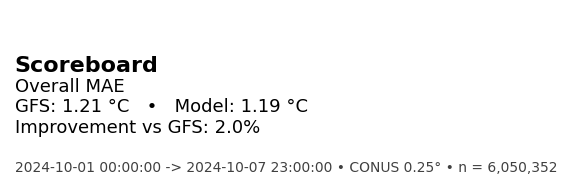

In [0]:
# Overall KPI
overall = to_pd("""
SELECT
  AVG(ABS(y_obs_c - gfs_t2m_c)) AS mae_gfs,
  AVG(ABS(y_obs_c - y_hat_c))   AS mae_model,
  COUNT(*) AS n
FROM v_eval
""")
mg = float(overall.mae_gfs.iloc[0])
mm = float(overall.mae_model.iloc[0])
N  = int(overall.n.iloc[0])
impr_pct = (mg - mm) / mg * 100.0 if mg else 0.0

subtitle = f"{START} -> {END} • CONUS 0.25° • n = {N:,}"

plt.figure(figsize=(3,2))
plt.axis('off')
txt = (f"Overall MAE\n"
       f"GFS: {mg:.2f} °C   •   Model: {mm:.2f} °C\n"
       f"Improvement vs GFS: {impr_pct:.1f}%")
plt.text(0.02, 0.60, "Scoreboard", fontsize=16, weight='bold')
plt.text(0.02, 0.20, txt, fontsize=13)
plt.text(0.02, -0.05, subtitle, fontsize=10, alpha=0.75)
plt.tight_layout()
plt.show()

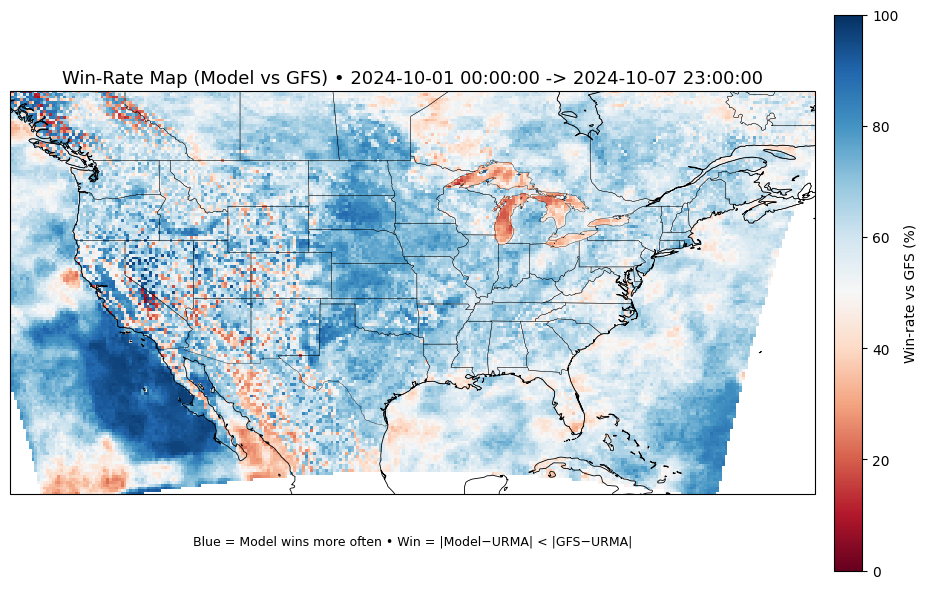

In [0]:
# ===== Win-Rate Map (aggregated over the same window) =====
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs, cartopy.feature as cfeature

CAT="weather_ml"; BRONZE=f"{CAT}.bronze"; SILVER=f"{CAT}.silver"; GOLD=f"{CAT}.gold"

START = "2024-10-01 00:00:00"
END   = "2024-10-07 23:00:00"
MIN_N = 24

q = f"""
WITH p AS (
  SELECT issue_time, valid_time,
         ROUND(CAST(lat AS DOUBLE),6) AS lat6,
         ROUND(CAST(lon AS DOUBLE),6) AS lon6,
         CAST(y_hat_c AS DOUBLE) AS y_hat_c
  FROM {GOLD}.predictions_grid_online
  WHERE issue_time BETWEEN TIMESTAMP('{START}') AND TIMESTAMP('{END}')
),
u AS (
  SELECT valid_time,
         ROUND(CAST(lat AS DOUBLE),6) AS lat6,
         ROUND(CAST(lon AS DOUBLE),6) AS lon6,
         CAST(y_obs_c AS DOUBLE) AS y_obs_c
  FROM {SILVER}.silver_urma_on_gfs
),
g AS (
  SELECT run_time AS issue_time,
         CAST(lead_hour AS INT) AS lead,
         ROUND(CAST(lat AS DOUBLE),6) AS lat6,
         ROUND(CAST(lon AS DOUBLE),6) AS lon6,
         CAST(value_c AS DOUBLE) AS gfs_t2m_c
  FROM {BRONZE}.bronze_gfs_grid
  WHERE var='t2m'
    AND run_time BETWEEN TIMESTAMP('{START}') AND TIMESTAMP('{END}')
),
pu AS (
  SELECT
    p.issue_time, p.valid_time, p.lat6, p.lon6, p.y_hat_c, u.y_obs_c,
    CAST(ROUND((unix_timestamp(p.valid_time) - unix_timestamp(p.issue_time)) / 3600.0) AS INT) AS lead
  FROM p JOIN u
    ON p.valid_time = u.valid_time AND p.lat6 = u.lat6 AND p.lon6 = u.lon6
)
SELECT pu.lat6, pu.lon6,
       ABS(pu.y_obs_c - pu.y_hat_c)  AS ae_model,
       ABS(pu.y_obs_c - g.gfs_t2m_c) AS ae_gfs
FROM pu JOIN g
  ON g.issue_time = pu.issue_time AND g.lead = pu.lead
 AND g.lat6 = pu.lat6 AND g.lon6 = pu.lon6
WHERE pu.lead BETWEEN 3 AND 8
"""
df = spark.sql(q).toPandas()
for c in ["lat6","lon6","ae_model","ae_gfs"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df["win"] = (df["ae_model"] < df["ae_gfs"]).astype("float32")
agg = (df.groupby(["lat6","lon6"])
         .agg(win_rate=("win","mean"), n=("win","size"))
         .reset_index())
agg["win_pct"] = 100.0 * agg["win_rate"].astype(float)

lats = np.sort(agg["lat6"].unique())
lons = np.sort(agg["lon6"].unique())
Z_win = (agg.pivot(index="lat6", columns="lon6", values="win_pct")
             .reindex(index=lats, columns=lons).values)
Z_n   = (agg.pivot(index="lat6", columns="lon6", values="n")
             .reindex(index=lats, columns=lons).values)

Z_plot = Z_win.copy().astype(float)
Z_plot[Z_n < MIN_N] = np.nan

extent = [float(lons.min()), float(lons.max()), float(lats.min()), float(lats.max())]
norm = TwoSlopeNorm(vmin=0, vcenter=50, vmax=100)

title = f"Win-Rate Map (Model vs GFS) • {START} -> {END}"
subtitle = "Blue = Model wins more often • Win = |Model−URMA| < |GFS−URMA|"

fig = plt.figure(figsize=(10,6))
ax  = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())

im = ax.pcolormesh(lons, lats, Z_plot, cmap="RdBu", norm=norm,
                   shading="auto", transform=ccrs.PlateCarree())
ax.coastlines(resolution="50m", linewidth=0.6)
try:
    ax.add_feature(cfeature.STATES.with_scale("50m"), linewidth=0.25, edgecolor="k")
except Exception:
    pass

cb = plt.colorbar(im, ax=ax, pad=0.02)
cb.set_label("Win-rate vs GFS (%)")

ax.set_title(title, fontsize=13, pad=6)
ax.text(0.5, -0.10, subtitle, ha="center", va="top",
        transform=ax.transAxes, fontsize=9)
plt.tight_layout()
plt.show()

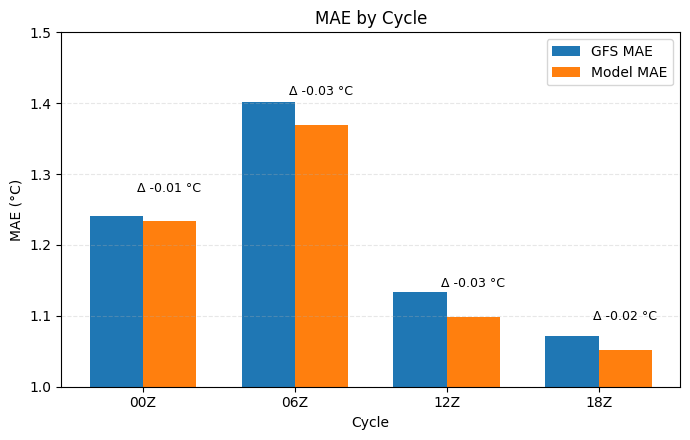

In [0]:
# MAE by cycle
mae_cycle = to_pd("""
SELECT HOUR(issue_time) AS zhr,
       AVG(ABS(y_obs_c - gfs_t2m_c))  AS mae_gfs,
       AVG(ABS(y_obs_c - y_hat_c))    AS mae_model,
       COUNT(*) AS n
FROM v_eval
GROUP BY HOUR(issue_time)
ORDER BY zhr
""")

mae_cycle["zlabel"] = mae_cycle["zhr"].map({0:"00Z",6:"06Z",12:"12Z",18:"18Z"})
mae_cycle["mae_gfs"] = mae_cycle["mae_gfs"].astype(float)
mae_cycle["mae_model"] = mae_cycle["mae_model"].astype(float)
mae_cycle["delta"] = mae_cycle["mae_model"] - mae_cycle["mae_gfs"]

fig, ax = plt.subplots(figsize=(7, 4.5))
idx = np.arange(len(mae_cycle))
w = 0.35
ax.bar(idx - w/2, mae_cycle["mae_gfs"].values, width=w, label="GFS MAE")
ax.bar(idx + w/2, mae_cycle["mae_model"].values, width=w, label="Model MAE")

ymin = float(min(mae_cycle["mae_gfs"].min(), mae_cycle["mae_model"].min()))
ymax = float(max(mae_cycle["mae_gfs"].max(), mae_cycle["mae_model"].max()))
pad = max(0.03, 0.12 * (ymax - ymin) if ymax > ymin else 0.05)
lo, hi = max(0.0, ymin - pad), ymax + pad
if lo >= 1.0 and hi <= 1.5:
    ax.set_ylim(1.0, 1.5)
else:
    ax.set_ylim(lo, hi)

for i in range(len(mae_cycle)):
    y_model = mae_cycle["mae_model"].iloc[i]
    d = mae_cycle["delta"].iloc[i]
    ax.text(idx[i] + w/2, y_model + pad * 0.90, f"Δ {d:+.2f} °C",
            ha="center", va="bottom", fontsize=9)

ax.set_xticks(idx)
ax.set_xticklabels(mae_cycle["zlabel"].tolist())
ax.set_xlabel("Cycle")
ax.set_ylabel("MAE (°C)")
ax.set_title("MAE by Cycle")
ax.legend(loc="best")
ax.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

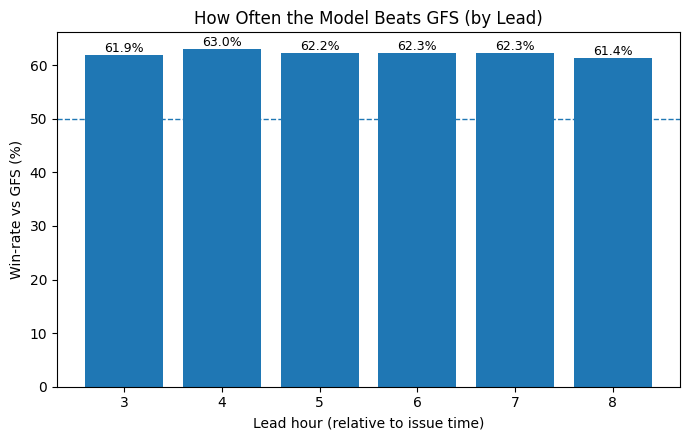

In [0]:
# Win rate by lead (fraction of points where |model error| < |GFS error|)
win_lead = to_pd("""
SELECT lead,
       AVG(CASE WHEN ABS(y_obs_c - y_hat_c) < ABS(y_obs_c - gfs_t2m_c) THEN 1.0 ELSE 0.0 END) AS win_rate,
       COUNT(*) AS n
FROM v_eval
GROUP BY lead
ORDER BY lead
""")
win_lead["pct"] = 100.0 * pd.to_numeric(win_lead["win_rate"])

plt.figure(figsize=(7,4.5))
x = win_lead["lead"].astype(int).values
y = win_lead["pct"].values
bars = plt.bar(x, y)
for i, v in enumerate(y):
    plt.text(x[i], v, f"{v:.1f}%", ha="center", va="bottom", fontsize=9)
plt.axhline(50, linestyle="--", linewidth=1)
plt.xlabel("Lead hour (relative to issue time)")
plt.ylabel("Win-rate vs GFS (%)")
plt.title("How Often the Model Beats GFS (by Lead)")
plt.tight_layout()
plt.show()

In [0]:
#